> [!Warning] 
> **This project is still in an early phase of development.**
>
> The [python API](https://c-star.readthedocs.io/en/latest/api.html) is not yet stable, and some aspects of the schema for the [blueprint](https://c-star.readthedocs.io/en/latest/terminology.html#term-blueprint) will likely evolve. 
> Therefore whilst you are welcome to try out using the package, we cannot yet guarantee backwards compatibility. 
We expect to reach a more stable version in Q1 2025.
>
> To see which systems C-Star has been tested on so far, see [Supported Systems](https://c-star.readthedocs.io/en/latest/machines.html).

> [!Warning]
> 
> This notebook assumes you are running the NERSC Perlmutter HPC machine.
> You will need to change some arguments in order to run this notebook verbatim on any other machine.

# Importing & running a `Case`
On this page, we will spin up a ROMS-MARBL run using C-Star. In particular, we will:

- Create a [C-Star Case](https://c-star.readthedocs.io/en/latest/terminology.html#term-Case) from a pre-prepared [blueprint](https://c-star.readthedocs.io/en/latest/terminology.html#term-blueprint) (`Case.from_blueprint()`). See [this page](https://c-star.readthedocs.io/en/latest/1_building_a_case_and_exporting_it_as_a_blueprint.html) for more information on blueprints and how to create them.
- Examine the contents of the Case object we just created
- Set up the case locally (`Case.setup()`)
- Compile any necessary code associated with the case (`Case.build()`)
- Complete any pre-processing steps associated with the case (`Case.pre_run()`)
- Run the case with a small time step for a couple of days (`Case.run()`)
- Execute any post-processing steps associated with the case (`Case.post_run()`)

## Importing the `Case` 
[The "Case"](https://c-star.readthedocs.io/en/latest/generated/cstar.Case.html) is the primary object of C-Star, and contains all the information needed to run a particular simulation. Once prepared, cases can be stored in "blueprints" - `.yaml` files telling C-Star what goes into each case and where to find it. We will start from a blueprint that has been prepared in advance.

We can construct a `Case` from a blueprint using the `Case.from_blueprint` method. The case we'll be looking at in this example is a January 2012 simulation of ocean physics and biogeochemistry around the Welsh coast, small enough to run on a laptop.

In [1]:
import cstar

example_case_1 = cstar.Case.from_blueprint(blueprint  = "https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example/raw/main/cstar_blueprint_example.yaml",
                                           caseroot   = "../examples/example_case", 
                                           start_date = "2012-01-01 12:00:00", 
                                           end_date   = "2012-01-03 12:00:00")

## Deconstructing the `Case` 

In [2]:
print(example_case_1)

C-Star Case
-----------
Name: roms_marbl_cstar_example
caseroot: /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/examples/example_case
start_date: 2012-01-01 12:00:00
end_date: 2012-01-03 12:00:00
Is setup: False
Valid date range:
valid_start_date: 2012-01-01 12:00:00
valid_end_date: 2012-01-31 12:00:00
This case was instantiated from the blueprint file:
   https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example/raw/main/cstar_blueprint_example.yaml

It is built from the following Components (query using Case.components): 
   <MARBLComponent instance>
   <ROMSComponent instance>


We can see in the printout:

- the values of the three parameters we provided (`caseroot`, `start_date`, `end_date`)
- the valid date range in which we can run this `Case`, as defined in the blueprint file (`valid_start_date`, `valid_end_date`)
- the blueprint file from which the `Case` was created
- that the `Case` is _not_ setup (yet)
- that the `Case` consists of two "`Component`"s (ROMS and MARBL)

### Looking at the `Component`s of our `Case`  
Above we saw that our `Case` consists of two `Component`s. 

The `Component` object represents a distinct model combined with any additional code and data needed to run it in a particular configuration. Let's take a look at our two `Component` instances:

#### MARBL

In [3]:
marbl_component = example_case_1.components[0]
print(marbl_component)

MARBLComponent
--------------
base_model: MARBLBaseModel instance (query using Component.base_model)


The first entry in the `components` list is [MARBL](https://c-star.readthedocs.io/en/latest/generated/cstar.marbl.MARBLComponent.html).

Our set-up for MARBL is very simple and requires no additional code or input data, just a `BaseModel`. 

The `BaseModel` [object](https://c-star.readthedocs.io/en/latest/generated/cstar.base.BaseModel.html) represents the off-the-shelf source code for our `Component`'s model, absent any modifications:

In [4]:
print(marbl_component.base_model)

MARBLBaseModel
--------------
source_repo : https://github.com/marbl-ecosys/MARBL.git (default)
checkout_target : marbl0.45.0 (corresponding to hash 6e6b2f7c32ac5427e6cf46de4222973b8bcaa3d9)
local_config_status: 3 (Environment variable MARBL_ROOT is not present and it is assumed the base model is not installed locally)


Here we see that the base model for MARBL:

- comes from the "default" source repository (that is, the one maintained by the MARBL developers)
- Is to be checked out at version 0.45
- Is _not_ configured for use on this machine (yet)

#### ROMS
Our ROMS Component consists of much more than just a base model with no modifications. Let's take a look:

In [5]:
roms_component = example_case_1.components[1]
print(roms_component)

ROMSComponent
-------------
base_model: ROMSBaseModel instance (query using Component.base_model)
additional_source_code: AdditionalCode instance with 9 files (query using Component.additional_source_code)
namelists: AdditionalCode instance with 4 files (query using Component.namelists)
model_grid = <ROMSModelGrid instance>
initial_conditions = <ROMSInitialConditions instance>
tidal_forcing = <ROMSTidalForcing instance>
surface_forcing = <list of 2 ROMSSurfaceForcing instances>
boundary_forcing = <list of 2 ROMSBoundaryForcing instances>

Discretization:
ROMSDiscretization
------------------
time_step: 60s
n_procs_x: 3 (Number of x-direction processors)
n_procs_y: 3 (Number of y-direction processors)


Here we see that we have a base model, as before, but also:

- additional source code to be compiled alongside the base model source code
- namelist files to define certain settings at runtime
- a range of input datasets defining everything from the model grid to the surface forcing. 

Let's take a look at a few examples, but feel free to explore the other parts of the ROMS `Component` yourself:

##### Additional source code

This is managed as an [AdditionalCode object](https://c-star.readthedocs.io/en/latest/generated/cstar.base.AdditionalCode.html) in C-Star. We see that in this case our code is kept in a subdirectory of a GitHub repository with 9 files in it.

In [6]:
print(roms_component.additional_source_code)

AdditionalCode
--------------
Location: https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git
subdirectory: roms_compile_time_code
Working path: None
Exists locally: False (get with AdditionalCode.get())
Files:
    bgc.opt
    bulk_frc.opt
    cppdefs.opt
    diagnostics.opt
    ocean_vars.opt
    param.opt
    tracers.opt
    Makefile
    Make.depend


We can see the full list of files using:


In [7]:
print(roms_component.additional_source_code.files)

['bgc.opt', 'bulk_frc.opt', 'cppdefs.opt', 'diagnostics.opt', 'ocean_vars.opt', 'param.opt', 'tracers.opt', 'Makefile', 'Make.depend']


##### Input datasets
Let's take a look at one of the input datasets:

In [8]:
print(roms_component.initial_conditions)

---------------------
ROMSInitialConditions
---------------------
Source location: https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example/raw/main/input_datasets_yaml/roms_ini.yaml
Working path: None ( does not yet exist. Call InputDataset.get() )


<div class="alert alert-info">

Note

1. The `location` attribute can either be a **local path** or a **URL**. If providing a URL to a binary (e.g. netcdf) file, the `file_hash` (a 256 bit checksum) must also be provided to verify the download.
    
2. The file described by location can be either **netCDF** or **yaml** format. When C-Star sees a yaml file instead of a netCDF file for ROMS input data, it assumes the file contains a set of instructions to be passed to the [`roms-tools` package](https://roms-tools.readthedocs.io/en/latest/), which will then generate the netCDF file for us when `InputDataset.get()` is called. This makes it easier to share and save ROMS configurations without the overhead associated with potentially large netCDF files. More information on using `roms-tools` with C-Star can be found on [this page](https://c-star.readthedocs.io/en/latest/4_preparing_roms_input_datasets.html)

</div>

##### Discretization
Lastly, the `discretization` attribute consists of essential information for compiling and running the model - the time step and the number of processors to assign in each direction:

In [9]:
print(roms_component.discretization)

ROMSDiscretization
------------------
time_step: 60s
n_procs_x: 3 (Number of x-direction processors)
n_procs_y: 3 (Number of y-direction processors)


## Visualizing the `Case`:
We can visualize everything we've just seen using the `Case.tree()` method, which prints a representation of how this `Case` will look in the `caseroot` once set up:

In [10]:
example_case_1.tree()

/global/cfs/cdirs/m4746/Users/dafydd/my_c_star/examples/example_case
├── input_datasets
│   └── ROMS
│       ├── roms_grd.yaml
│       ├── roms_ini.yaml
│       ├── roms_tides.yaml
│       ├── roms_bry.yaml
│       ├── roms_bry_bgc.yaml
│       ├── roms_frc.yaml
│       └── roms_frc_bgc.yaml
├── namelists
│   └── ROMS
│       ├── roms.in_TEMPLATE
│       ├── marbl_in
│       ├── marbl_tracer_output_list
│       └── marbl_diagnostic_output_list
└── additional_source_code
    └── ROMS
        ├── bgc.opt
        ├── bulk_frc.opt
        ├── cppdefs.opt
        ├── diagnostics.opt
        ├── ocean_vars.opt
        ├── param.opt
        ├── tracers.opt
        ├── Makefile
        └── Make.depend



<div class="alert alert-info">

Note

Nothing we have seen above represents anything local on our machine (yet). each object simply describes where various files may be found, and the `Case.tree()` representation shows us where these files will be assembled once we set everything up. To turn that into something concrete we can work with, we call `Case.setup()`.

</div>

## Setting up the `Case` :

Next we call `Case.setup()`. This will:

- Fetch and compile our base models (ROMS and MARBL)
- Fetch any remote data associated with this case
- Construct any ROMS netCDF files from yaml files using `roms-tools` 

We will be prompted before installing the base models, so some input is required here:

In [11]:
example_case_1.setup()


Setting up MARBLComponent
--------------------------
Configuring MARBLComponent
--------------------------
#######################################################
C-STAR: MARBL_ROOT not found in current cstar_sysmgr.environment. 
if this is your first time running C-Star with an instance of MARBLBaseModel, you will need to set it up.
It is recommended that you install this base model in 
/global/cfs/cdirs/m4746/Users/dafydd/my_c_star/cstar/externals/MARBL
This will also modify your `~/.cstar.env` file.
#######################################################


Would you like to do this now? ('y', 'n', or 'custom' to install at a custom path)
 y


Cloned repository https://github.com/marbl-ecosys/MARBL.git to /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/cstar/externals/MARBL
Checked out marbl0.45.0 in git repository /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/cstar/externals/MARBL
Updating environment in C-Star configuration file ~/.cstar.env
Updating environment in C-Star configuration file /global/homes/d/dafydd/.cstar.env
Compiling MARBL...
MARBL successfully installed at /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/cstar/externals/MARBL

Setting up ROMSComponent
-------------------------
Configuring ROMSComponent
-------------------------
#######################################################
C-STAR: ROMS_ROOT not found in current cstar_sysmgr.environment. 
if this is your first time running C-Star with an instance of ROMSBaseModel, you will need to set it up.
It is recommended that you install this base model in 
/global/cfs/cdirs/m4746/Users/dafydd/my_c_star/cstar/externals/ucla-roms
This will also modify your `~/.

Would you like to do this now? ('y', 'n', or 'custom' to install at a custom path)
 y


Cloned repository https://github.com/CESR-lab/ucla-roms.git to /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/cstar/externals/ucla-roms
Checked out 52adceac25670ee985d741d1bad62639dac3d183 in git repository /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/cstar/externals/ucla-roms
Updating environment in C-Star configuration file ~/.cstar.env
Compiling UCLA ROMS' NHMG library...
Compiling Tools-Roms package for UCLA ROMS...
UCLA-ROMS is installed at /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/cstar/externals/ucla-roms

Fetching additional source code...
----------------------------------
Cloned repository https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git to /tmp/tmpb0_xl6i8
Checked out main in git repository /tmp/tmpb0_xl6i8
copying bgc.opt to /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/examples/example_case/additional_source_code/ROMS
copying bulk_frc.opt to /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/examples/example_case/additional_source_code/ROMS
copyi

INFO - Selected time entry closest to the specified start_time (2012-01-01 12:00:00) within the range [2012-01-01 12:00:00, 2012-01-02 12:00:00]: ['2012-01-01T12:00:00.000000000']


Saving roms-tools dataset created from https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example/raw/main/input_datasets_yaml/roms_ini.yaml...
[########################################] | 100% Completed | 5.67 sms
Saving roms-tools dataset created from https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example/raw/main/input_datasets_yaml/roms_tides.yaml...
[########################################] | 100% Completed | 2.32 sms
Saving roms-tools dataset created from https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example/raw/main/input_datasets_yaml/roms_bry.yaml...
[########################################] | 100% Completed | 2.91 sms
Saving roms-tools dataset created from https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example/raw/main/input_datasets_yaml/roms_bry_bgc.yaml...
[########################################] | 100% Completed | 38.14 s
Saving roms-tools dataset created from https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_

If we attempt to run `Case.setup()` again, C-Star identifies that nothing has changed from our previous `setup()` call and we can skip this step:

In [12]:
example_case_1.setup()

This case appears to have already been set up at /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/examples/example_case


<div class="alert alert-info">

Note

C-Star currently does not maintain the state of Cases between sessions. This means that, if you run `Case.setup()`, exit your python session, start a new one, and create the Case again from the same blueprint, you will have to run `Case.setup()` again to re-establish the working state of the `Case`, even though this `Case` has already been set up. Most setup steps will be skipped the second time, as C-Star will see they are already complete.
</div>

## Compiling the `Case` and performing pre-processing
We have now assembled all the data we need to run this `Case` in one place. Lastly, we need to compile the additional code we've obtained and run some pre-processing steps on the input data:

In [13]:
#The Case.build() method compiles the code:
example_case_1.build()


Compiling MARBLComponent
-------------------------
No build steps to be completed for MARBLComponent

Compiling ROMSComponent
------------------------
Compiling UCLA-ROMS configuration...
UCLA-ROMS compiled at /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/examples/example_case/additional_source_code/ROMS


In [14]:
# The Case.pre_run() method performs pre-processing:
example_case_1.pre_run()


Completing pre-processing steps for MARBLComponent
---------------------------------------------------
No pre-processing steps to be completed for MARBLComponent

Completing pre-processing steps for ROMSComponent
--------------------------------------------------
Partitioning /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/examples/example_case/input_datasets/ROMS/roms_grd.nc into (3,3)
Partitioning /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/examples/example_case/input_datasets/ROMS/roms_ini.nc into (3,3)
Partitioning /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/examples/example_case/input_datasets/ROMS/roms_tides.nc into (3,3)
Partitioning /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/examples/example_case/input_datasets/ROMS/roms_bry.nc into (3,3)
Partitioning /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/examples/example_case/input_datasets/ROMS/roms_bry_bgc.nc into (3,3)
Partitioning /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/examples/example_case/input_datasets/ROMS/ro

## Running the `Case` :

In [15]:
hpc_job = example_case_1.run(account_key="m4746", walltime="00:10:00", queue_name="shared")


Running ROMS... 


<div class="alert alert-info">

Note

The arguments provided to `Case.run()` here are for use on a supported HPC system. The command submits a job to the HPC's scheduler system and returns a [`SchedulerJob`](https://c-star.readthedocs.io/en/latest/generated/cstar.scheduler.job.html) instance. 
    
If running on a personal computer, or system without a job scheduler, simply call `Case.run()` with no arguments - the command will return `None`.

</div>

We can track the status of the submitted job using [`SchedulerJob.status`](https://c-star.readthedocs.io/en/latest/generated/cstar.scheduler.SchedulerJob.status.html#cstar.scheduler.SchedulerJob.status). It will change from:

In [16]:
hpc_job.status

<ExecutionStatus.PENDING: 2>

(while in the queue) to:

In [17]:
hpc_job.status

<ExecutionStatus.RUNNING: 3>

(while executing) to:

In [18]:
hpc_job.status

<ExecutionStatus.COMPLETED: 4>

(when finished). 

For more information on handling jobs on supported HPC systems, see the [corresponding doc page](https://c-star.readthedocs.io/en/latest/5_handling_jobs_on_hpc_systems.html).

## Post-processing
Once the run is complete, we can carry out any post-processing steps.
When ROMS runs on multiple CPUs in parallel, it produces one output file per CPU. To work with the output, we thus need to join these files together. This is handled with the `post_run()` method:

In [19]:
example_case_1.post_run()


Completing post-processing steps for ROMSComponent
---------------------------------------------------
Joining netCDF files ROMS_MARBL_rst.20120103120000.*.nc...
Joining netCDF files ROMS_MARBL_bgc.20120101120000.*.nc...
Joining netCDF files ROMS_MARBL_bgc_dia.20120101120000.*.nc...
Joining netCDF files ROMS_MARBL_rst.20120102120000.*.nc...
Joining netCDF files ROMS_MARBL_his.20120101120000.*.nc...


## A quick look at the output

In the above post-processing step, we can see that the ROMS run produced several "restart" files (`ROMS_MARBL_rst.*`) that can be used by ROMS to restart the run.
On the [next page](https://c-star.readthedocs.io/en/latest/3_restarting_and_continuing_a_case.html), we will use C-Star to restart and continue our Case, and C-Star will find and use these files to do so.

For now, let's produce a plot comparing the initial condition we started with with the final restart file (which will serve as the initial condition on the [next page](https://c-star.readthedocs.io/en/latest/3_restarting_and_continuing_a_case.html)).

C-Star doesn't currently support plots of model data, so we will have to manually produce these using the model files. Don't worry too much about understanding the model's naming conventions in this code cell (C-Star will usually take care of these things for you) - this is just a visual demonstration!

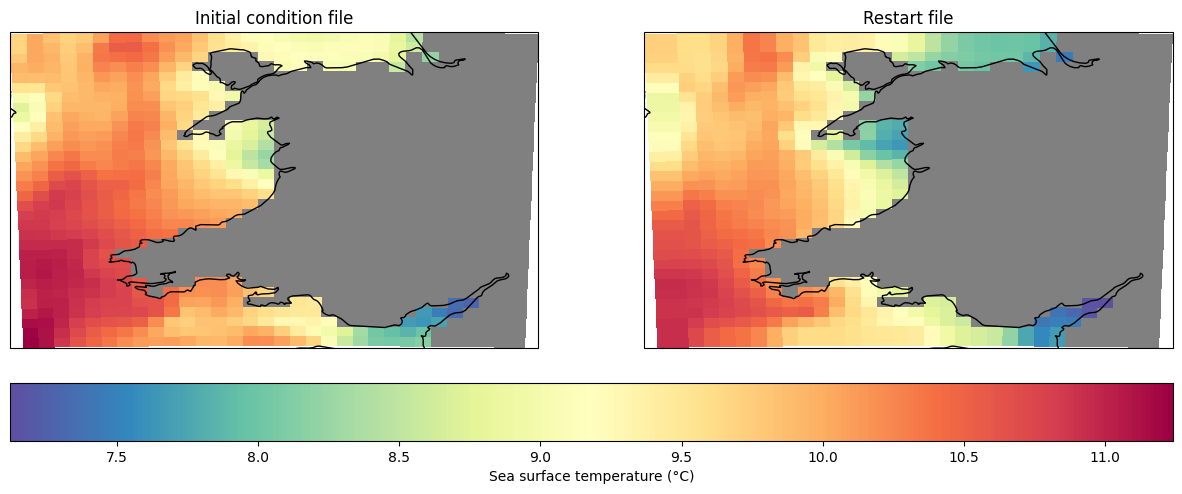

In [20]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

grd_ds = xr.open_dataset(example_case_1.caseroot / 'input_datasets/ROMS/roms_grd.nc') # Our ROMS grid file for lat and lon data
ini_ds = xr.open_dataset(example_case_1.caseroot / 'input_datasets/ROMS/roms_ini.nc') # Our initial condition file
rst_ds = xr.open_dataset(example_case_1.caseroot / 'output/ROMS_MARBL_rst.20120103120000.nc') # Our restart file

var="temp"
ini_data = ini_ds[var].where(grd_ds.mask_rho).isel(s_rho=-1, ocean_time=0)
rst_data = rst_ds[var].where(grd_ds.mask_rho).isel(s_rho=-1, time=0)

# Create figure and axes
fig, ax = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 9))

# Plot the data
cmap=plt.get_cmap('Spectral_r')
cmap.set_bad('gray')
vmin = min(ini_data.where(grd_ds.mask_rho).min(), rst_data.where(grd_ds.mask_rho).min())
vmax = max(ini_data.where(grd_ds.mask_rho).max(), rst_data.where(grd_ds.mask_rho).max())
kwargs = {"cmap": cmap, "vmin": vmin, "vmax": vmax}
p0=ax[0].pcolormesh(grd_ds.lon_rho, grd_ds.lat_rho, ini_data, transform=ccrs.PlateCarree(), **kwargs)
p1=ax[1].pcolormesh(grd_ds.lon_rho, grd_ds.lat_rho, rst_data, transform=ccrs.PlateCarree(), **kwargs)

# Add coastlines and land mask 
[a.add_feature(cfeature.COASTLINE, linewidth=1) for a in ax]

# Add a colorbar
ax[0].set_title("Initial condition file")
ax[1].set_title("Restart file")
plt.colorbar(p1, ax=ax, orientation='horizontal', pad=0.05,label="Sea surface temperature (°C)")
fig.show()
grd_ds.close()


## Summary

On this page we:

- created a C-Star `Case` from a "blueprint" file
- Ran the case for 5 days from 2012-01-01 to 2012-01-03 with a 1 minute time-step
- Produced a basic plot to verify the output